<a href="https://colab.research.google.com/github/lilyjiang789/brain-tumor-detection/blob/main/main_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lilyjiangm","key":"7f14e90c696e0d59fc8ca8aa69393d48"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT


In [ ]:
!unzip -q brain-tumor-classification-mri.zip -d dataset


In [ ]:
!pip install tensorflow pillow tqdm numpy matplotlib

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [5]:
import os
import tqdm
import numpy as np
from PIL import Image
import tensorflow as tf
x_training = []
y_training = []

image_size = 150

for i in labels:
    train_dir = os.path.join("./dataset", "Training", i)
    for file in tqdm.tqdm(os.listdir(train_dir)):
        img = Image.open(os.path.join(train_dir, file))
        img = img.resize((image_size, image_size))
        img_array = np.array(img) / 255.0
        x_training.append(img_array)
        y_training.append(i)

x_testing = []
y_testing = []

for i in labels:
    test_dir = os.path.join("./dataset", "Testing", i)
    for file in tqdm.tqdm(os.listdir(test_dir)):
        img = Image.open(os.path.join(test_dir, file))
        img = img.resize((image_size, image_size))
        img_array = np.array(img) / 255.0
        x_testing.append(img_array)
        y_testing.append(i)

x_training = np.array(x_training)
y_training = np.array(y_training)
x_testing = np.array(x_testing)
y_testing = np.array(y_testing)

100%|██████████| 74/74 [00:00<00:00, 110.83it/s]


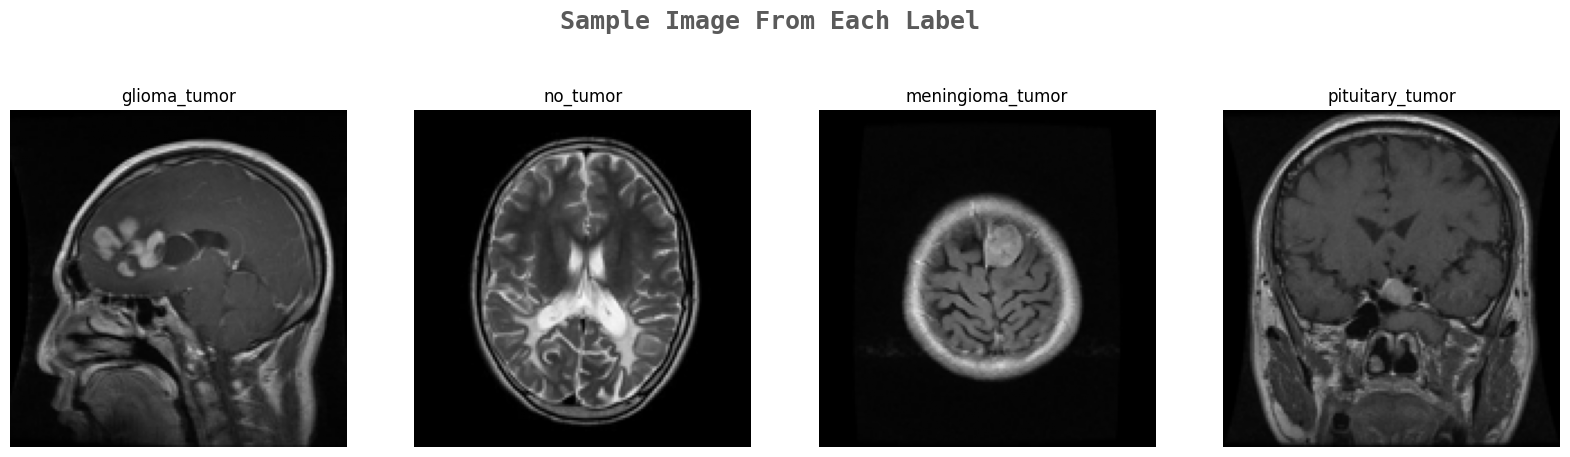

In [6]:
import matplotlib.pyplot as plt

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    for j in range(len(y_training)):
        if y_training[j]==i:
            ax[k].imshow(x_training[j])
            ax[k].set_title(y_training[j])
            ax[k].axis('off')
            k+=1
            break

In [7]:
y_train_new = []
for i in y_training:
    y_train_new.append(labels.index(i))
y_training = y_train_new
y_training = tf.keras.utils.to_categorical(y_training)


y_test_new = []
for i in y_testing:
    y_test_new.append(labels.index(i))
y_testing = y_test_new
y_testing = tf.keras.utils.to_categorical(y_testing)

# Training the Model

In [8]:
from tensorflow.keras.applications import EfficientNetB0

effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [9]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [10]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [12]:
from sklearn.utils.class_weight import compute_class_weight
y_labels = np.argmax(y_training, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

history = model.fit(x_training,y_training,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr], class_weight=class_weights)

Class Weights: {0: np.float64(0.8686440677966102), 1: np.float64(1.8164556962025316), 2: np.float64(0.8728710462287105), 3: np.float64(0.8675937122128174)}
Epoch 1/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.7160 - loss: 0.6826
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to effnet.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 150s 732ms/step - accuracy: 0.7172 - loss: 0.6800 - val_accuracy: 0.0000e+00 - val_loss: 2.8565 - learning_rate: 0.0010
Epoch 2/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9030 - loss: 0.2373
Epoch 2: val_accuracy did not improve from 0.00000
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9031 - loss: 0.2373 - val_accuracy: 0.0000e+00 - val_loss: 3.4819 - learning_rate: 0.0010
Epoch 3/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9533 - loss: 0.1373
Epoch 3: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9531 - loss: 0.1375 - val_accuracy: 0.0000e+00 - val_loss: 4.1386 - learning_rate: 0.0010
Epoch 4/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9750 - loss: 0.0759
Epoch 4: val_accuracy did not improve from 0.00000
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9750 - loss: 0.0758 - v

81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.2021 - val_loss: 2.1505 - learning_rate: 9.0000e-05
Epoch 8/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9959 - loss: 0.0237
Epoch 8: val_accuracy did not improve from 0.20209
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9959 - loss: 0.0237 - val_accuracy: 0.0000e+00 - val_loss: 5.6849 - learning_rate: 9.0000e-05
Epoch 9/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9943 - loss: 0.0174
Epoch 9: val_accuracy did not improve from 0.20209

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9943 - loss: 0.0174 - val_accuracy: 0.0070 - val_loss: 3.6438 - learning_rate: 9.0000e-05
Epoch 10/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9975 - loss: 0.0089
Epoch 10: val_accuracy did not improve from 0.20209
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9975 - loss: 0.0089 - 

81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9992 - loss: 0.0070 - val_accuracy: 0.7526 - val_loss: 0.6289 - learning_rate: 2.7000e-05
Epoch 12/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9995 - loss: 0.0053
Epoch 12: val_accuracy improved from 0.75261 to 0.96167, saving model to effnet.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9995 - loss: 0.0054 - val_accuracy: 0.9617 - val_loss: 0.1141 - learning_rate: 2.7000e-05


In [13]:
from sklearn.metrics import classification_report
pred = model.predict(x_testing)
pred = np.argmax(pred,axis=1)
y_testing_new = np.argmax(y_testing,axis=1)
print(classification_report(y_test_new,pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 898ms/step
              precision    recall  f1-score   support

           0       1.00      0.19      0.32       100
           1       0.77      1.00      0.87       105
           2       0.61      1.00      0.76       115
           3       1.00      0.70      0.83        74

    accuracy                           0.74       394
   macro avg       0.85      0.72      0.69       394
weighted avg       0.83      0.74      0.69       394

